# Feature extraction

In [1]:
import polars as pl
ticker = pl.read_csv('data/MD/ticker.csv')
trades = pl.read_csv('data/MD/trades.csv')

In [2]:
trades = trades.sort("local_ts")
ticker = ticker.sort("local_ts")

In [3]:
trades = trades.with_columns(
    datetime = (pl.col("local_ts")).cast(pl.Datetime).dt.with_time_unit("ns"),
    volume = trades['price']*trades['amount']
)

In [4]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext heat
%load_ext line_profiler

In [5]:
side_trades = trades.select(['local_ts','volume']).to_numpy()
side_trades_window = np.zeros(side_trades.shape[0])
times = side_trades[:,0].astype('uint64')
vols = side_trades[:,1]
sides_indicator = (trades.select('side').to_numpy().reshape((-1))=='B').astype(int)*2-1

@njit()
def calc_window_jit(times,vols, side_ind,stop=None):
    window_size = 2e9
    wi = np.zeros((times.shape[0],))
    ind = 1
    for i, (time, vol, row_indicator) in enumerate(zip(times,vols,side_ind)):
        while ind+i<=times.shape[0]-1 and time + window_size >= times[ind+i]:
            ind += 1
        while ind+i<=times.shape[0]-1 and time + window_size <= times[ind+i]:
            ind -= 1
            
        wi[i:ind+i+1] += vol * row_indicator
        if stop is not None and i==stop:
            break
    return wi

calc_window_jit(times,vols, sides_indicator)

array([-2.80911000e+01, -1.12364400e+02, -3.09002100e+02, ...,
       -4.55759885e+04, -4.61522054e+04, -4.63442777e+04])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'TFI chart')

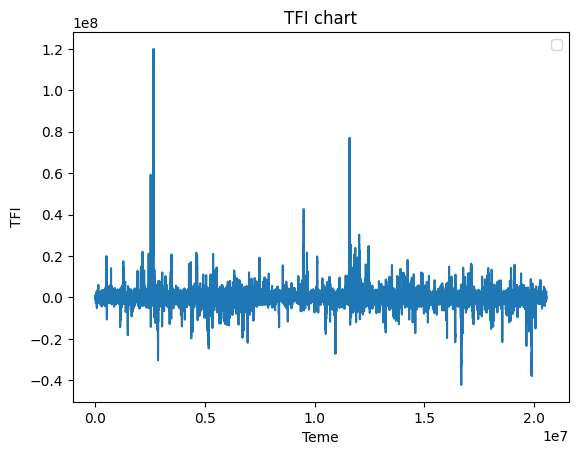

In [17]:
plt.plot(calc_window_jit(times,vols, sides_indicator))
plt.xlabel("Teme")
plt.ylabel("TFI")
plt.legend()
plt.title("TFI chart")

In [37]:
import pandas as pd
pd_data = pd.DataFrame(np.vstack((times,vols,sides_indicator)).T, columns=['ts','vol','sign'])
pd_data.loc[:,'ts'] = pd.to_datetime(pd_data.ts)

100%|██████████| 20/20 [16:30<00:00, 49.54s/it] 


Text(0.5, 1.0, 'Numba vs other implementations')

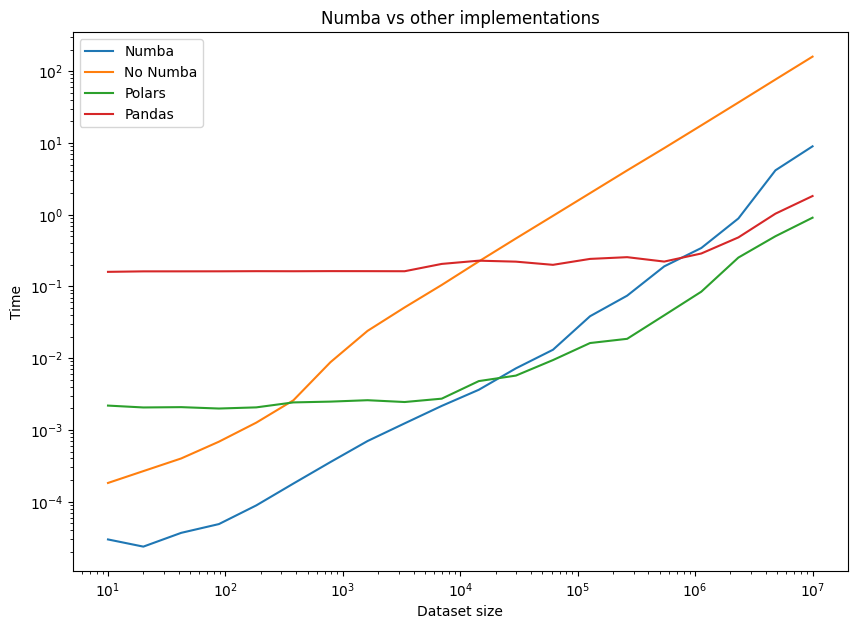

In [47]:
import time
from tqdm import tqdm
times_numba = []
times_no_numba = []
times_polars = []
times_pandas = []
sizes = np.logspace(1,7,20,dtype=int)
for dataset_size in tqdm(sizes):
    numba = []
    no_numba = []
    polars = []
    pandas_ = []
    for _ in range(3):
        
        start = time.perf_counter()
        calc_window_jit(times[:dataset_size],vols[:dataset_size], sides_indicator[:dataset_size])
        numba.append(time.perf_counter() - start)
        
        start = time.perf_counter()
        calc_window_jit.__wrapped__(times[:dataset_size],vols[:dataset_size], sides_indicator[:dataset_size])
        no_numba.append(time.perf_counter() - start)
        
        start = time.perf_counter()
        trades[:dataset_size].with_columns(
            TFI = (pl.when(pl.col("side") == 'B').then(pl.lit(1)).otherwise(pl.lit(-1)) * pl.col('volume')).rolling_sum(window_size='2000ms', min_periods =0, by = 'datetime', closed= 'both')
        )
        polars.append(time.perf_counter() - start)

        start = time.perf_counter()
        pd_data[:dataset_size].copy().assign(tfi=pd_data.sign*pd_data.vol)[['ts','tfi']].rolling(window='2000ms', min_periods=0, on='ts', closed='both').sum(engine='numba')
        pandas_.append(time.perf_counter() - start)
        
    times_numba.append(np.median(numba))
    times_no_numba.append(np.median(no_numba))
    times_polars.append(np.median(polars))
    times_pandas.append(np.median(pandas_))
plt.figure(figsize=(10,7))
plt.plot(sizes, times_numba, label = 'Numba')
plt.plot(sizes, times_no_numba, label = 'No Numba')
plt.plot(sizes, times_polars, label = 'Polars')
plt.plot(sizes, times_pandas, label = 'Pandas')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Dataset size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs other implementations")